In [7]:
import os
import pickle
import numpy as np
import scipy.stats as stt
import matplotlib.pyplot as plt

In [8]:
resultsdir = '/project_cephfs/3022017.06/projects/stijdboe/make_results/10_folds_results/'
cols = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [6]:
# Make an empty array
scores = np.zeros((4, 6, 10, 4))
# For each model type
model_types = ['Normal','SHASHb_1','SHASHb_2']
for i_m, model_type in enumerate(model_types):
    # For each feature
    features = ['Right-Cerebellum-White-Matter',
                'EstimatedTotalIntraCranialVol',
                'Right-Lateral-Ventricle',
                'WM-hypointensities',
                'rh_S_interm_prim-Jensen_thickness', 
                'Brain-Stem']
    for iif, feature in enumerate(features):
        # For each fold
        for f in range(10):
            path = os.path.join(resultsdir, f"fold_{f}_{model_type}/batch_{iif+1}/MAP_zscores/MAP_zscores_{iif}_{model_type}_fold{f}.pkl")
            # Get the z-scores
            with open(path, 'rb') as file:
                zscores = pickle.load(file)
                mean = np.mean(zscores)
                var = np.mean((zscores-mean)**2)
                skew = np.mean(((zscores-mean)/np.sqrt(var))**3)
                kurtosis = np.mean(((zscores-mean)/np.sqrt(var))**4)-3
                scores[i_m+1, iif, f, 0] = mean
                scores[i_m+1, iif, f, 1] = var
                scores[i_m+1, iif, f, 2] = skew
                scores[i_m+1, iif, f, 3] = kurtosis
        print(f"{np.round(scores[i_m+1, iif].mean(axis = 0),2)}, {model_type}, {feature}")
                # Compute the mean, var, skew, kurtosis
for iif, feature in enumerate(features):
    # For each fold
    for f in range(10):
        path = os.path.join(resultsdir, f"fold_{f}_blr/batch_{iif+1}/Z_estimate.txt")
        zscores = np.loadtxt(path)
        # Get the z-scores
        mean = np.mean(zscores)
        var = np.mean((zscores-mean)**2)
        skew = np.mean(((zscores-mean)/np.sqrt(var))**3)
        kurtosis = np.mean(((zscores-mean)/np.sqrt(var))**4)-3
        scores[0, iif, f, 0] = mean
        scores[0, iif, f, 1] = var
        scores[0, iif, f, 2] = skew
        scores[0, iif, f, 3] = kurtosis
    print(f"{np.round(scores[0, iif].mean(axis = 0),2)}, BLR, {feature}")


FileNotFoundError: [Errno 2] No such file or directory: '/project_cephfs/3022017.06/projects/stijdboe/make_results/10_folds_results/fold_0_Normal/batch_1/MAP_zscores/MAP_zscores_0_Normal_fold0.pkl'

In [4]:
meanscores = np.mean(scores, axis = 2)
varscores = np.std(scores, axis=2)
print(meanscores.shape)
# For each feature, make a row
# For each moment, print the SHASHo and the SHASHb score
for iff, feature in enumerate(features):
    print("\\texttt{"+feature+"}", "\t&", end = "")
    k = 0
    # For skew and kurtosis:
    for i in range(2,4):
        # For each model type
        for i_m in range(4):
            k+=1
            print(f"{round(meanscores[i_m, iff, i],2)}\t", end="")
            if k <8:
                print("&", end="")
    print("\\\\")

(4, 6, 4)
\texttt{Right-Cerebellum-White-Matter} 	&0.06	&1.33	&0.14	&0.14	&0.57	&6.04	&0.5	&0.5	\\
\texttt{EstimatedTotalIntraCranialVol} 	&-0.04	&0.04	&-0.01	&-0.01	&0.71	&1.33	&0.32	&0.29	\\
\texttt{Right-Lateral-Ventricle} 	&0.32	&2.75	&0.16	&0.13	&0.89	&26.69	&1.08	&0.58	\\
\texttt{WM-hypointensities} 	&0.34	&6.38	&0.33	&0.33	&0.5	&79.82	&1.52	&1.39	\\
\texttt{rh_S_interm_prim-Jensen_thickness} 	&0.03	&0.29	&0.0	&0.0	&0.3	&1.17	&0.12	&0.12	\\
\texttt{Brain-Stem} 	&-0.0	&0.31	&0.02	&0.03	&0.52	&0.91	&0.25	&0.24	\\


In [5]:
def Rsquared(z):
    zf = np.sort(np.reshape(z, (-1,)))
    norms = np.sort(np.random.randn(zf.shape[0]))
    sum_of_residuals = np.sum((zf-norms)**2)
    sum_of_squares = np.sum((zf-zf.mean())**2)
    return 1-(sum_of_residuals/sum_of_squares)

In [67]:
features = ['Right-Cerebellum-White-Matter',
            'EstimatedTotalIntraCranialVol',
            'Right-Lateral-Ventricle',
            'WM-hypointensities',
            'rh_S_interm_prim-Jensen_thickness', 
            'Brain-Stem']

ordered_features = ['Right-Cerebellum-White-Matter',
            'Right-Lateral-Ventricle',
            'WM-hypointensities',
            'EstimatedTotalIntraCranialVol',
            'rh_S_interm_prim-Jensen_thickness', 
            'Brain-Stem']
abbrevs = ['RCWM','RLV','WMH','ETICV','RIPJ','BS']
feature_namemap={k:v for k, v in zip(ordered_features,abbrevs)}
sorted_features = list(reversed(sorted(features, key=str.casefold)))
sorted_features = sorted(features, key=str.casefold)
lmap = {'SHASHb_1':'$\mathcal{S}_{b1}$', 'SHASHb_2':'$\mathcal{S}_{b2}$', 'Normal':'$\mathcal{N}$'}
def qqplot(fold=0, l='SHASHo', plotted_features = ordered_features, legend=False,ylabel=False):
    fig = plt.figure(figsize=(4, 3+len(plotted_features)/2))
    plt.xlim(-4,4)
    plt.ylim(-10,6)
    for iff, feature in enumerate(plotted_features):
        iff2 = features.index(feature)
        if l in ['SHASHb_1','SHASHb_2','Normal']:
            plt.title(f'HBR-{lmap[l]}', fontsize= 14)
            path_to_zscores = f"fold_{fold}_{l}/batch_{features.index(feature)+1}/MAP_zscores/MAP_zscores_{iff2}_{l}_fold{fold}.pkl"
            with open(os.path.join( '/project_cephfs/3022017.02/projects/stijdboe/make_results/10_folds_results/',path_to_zscores),'rb') as file:
                z_scores = pickle.load(file)
                plt.scatter(np.sort(np.random.randn(*z_scores.shape)),np.sort(z_scores)-iff, alpha = 0.1, color = cols[iff], s = 10, zorder=3)
        elif l == 'blr':
            plt.title('W-BLR', fontsize= 14)
            path_to_zscores = f"fold_{fold}_{l}/batch_{features.index(feature)+1}/Z_estimate.txt"
            z_scores = np.loadtxt(os.path.join('/project_cephfs/3022017.02/projects/stijdboe/make_results/10_folds_results/',path_to_zscores))
            plt.scatter(np.sort(np.random.randn(*z_scores.shape)),np.sort(z_scores)-iff, alpha = 0.1, color = cols[iff], s = 10, zorder=3)

        print(f"{l}, {feature}: {Rsquared(z_scores)}")


    plt.gca().set_prop_cycle(None)
    for iff, feature in enumerate(plotted_features):
#         iff2 = features.index(feature)

        plt.plot([-4,4],[-4-iff,4-iff], color=cols[iff], label = feature_namemap[feature])
        plt.plot([-4,4],[-4-iff,4-iff], color = 'black',linestyle = ":",alpha = 0.5, zorder=4)

    plt.xlabel("Theoretical quantiles", fontsize= 14)
    if ylabel:
        plt.ylabel(f"Estimated quantiles", fontsize= 14)
        plt.yticks(np.arange(-10,7))
    else:
        plt.yticks(np.arange(-10,7),[])
#     plt.tight_layout()
    if legend:
        plt.legend(fontsize=13)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.xticks(np.arange(-4,5))
    plt.grid(linewidth=1, linestyle=":",alpha = 0.7)
    #plt.savefig(f"/home/preclineu/stijdboe/Projects/MasterThesis/Latex/Thesis/imgs/qqplot-fold{fold}-{l}.png",bbox_inches='tight',dpi=300)
    plt.show()


In [68]:
for k in feature_namemap.keys():
    print(f"{k}: {feature_namemap[k]}",end=", ")

Right-Cerebellum-White-Matter: RCWM, Right-Lateral-Ventricle: RLV, WM-hypointensities: WMH, EstimatedTotalIntraCranialVol: ETICV, rh_S_interm_prim-Jensen_thickness: RIPJ, Brain-Stem: BS, 

blr, Right-Cerebellum-White-Matter: 0.9963121837246344
blr, Right-Lateral-Ventricle: 0.9900374153278966
blr, WM-hypointensities: 0.9945933929055791
blr, EstimatedTotalIntraCranialVol: 0.9964722072219567
blr, rh_S_interm_prim-Jensen_thickness: 0.9975129308280458
blr, Brain-Stem: 0.9990425948493072


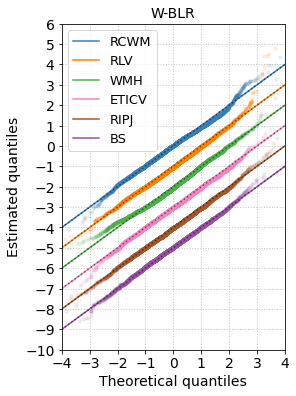

Normal, Right-Cerebellum-White-Matter: 0.9220950224882901
Normal, Right-Lateral-Ventricle: 0.8174911514476175
Normal, WM-hypointensities: 0.4625894975908149
Normal, EstimatedTotalIntraCranialVol: 0.9953976092373334
Normal, rh_S_interm_prim-Jensen_thickness: 0.9872323621745182
Normal, Brain-Stem: 0.9943958110189226


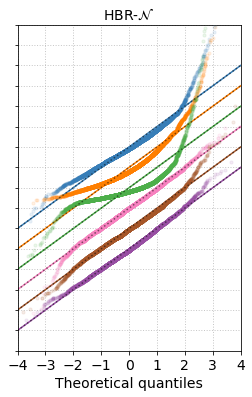

SHASHb_1, Right-Cerebellum-White-Matter: 0.9917423656585058
SHASHb_1, Right-Lateral-Ventricle: 0.9903505801304101
SHASHb_1, WM-hypointensities: 0.9725995987011204
SHASHb_1, EstimatedTotalIntraCranialVol: 0.9974526295318428
SHASHb_1, rh_S_interm_prim-Jensen_thickness: 0.9984498187767679
SHASHb_1, Brain-Stem: 0.9989382784275542


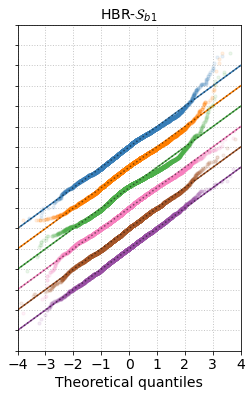

SHASHb_2, Right-Cerebellum-White-Matter: 0.99319620134997
SHASHb_2, Right-Lateral-Ventricle: 0.9920529931679849
SHASHb_2, WM-hypointensities: 0.980883834801236
SHASHb_2, EstimatedTotalIntraCranialVol: 0.9971710705950325
SHASHb_2, rh_S_interm_prim-Jensen_thickness: 0.9976229047562079
SHASHb_2, Brain-Stem: 0.9990698451464528


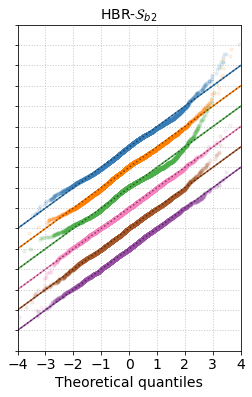

In [69]:
# qqplot(fold = 0, l='SHASHo')
# qqplot(fold = 0, l='SHASHb')
# qqplot(fold = 0, l='Normal')
fold = 0
qqplot(fold = fold, l='blr',legend=True,ylabel=True)
qqplot(fold = fold, l='Normal')
qqplot(fold = fold, l='SHASHb_1')
qqplot(fold = fold, l='SHASHb_2')
